<a href="https://colab.research.google.com/github/Varvara1991/Our_Poject/blob/My_branch/video_mask_r_cnn_%2B_iou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyyaml==5.1
# Версия torch 1.9.0
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# 
# Инструкции https://detectron2.readthedocs.io/tutorials/install.html 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
##### ПЕРЕЗАПУСТИТЕ СРЕДУ ####

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 14.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ea17c76bae405a166ebf3f6d9603f5bd0336139403c88821d92c002d9e08c124
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org

In [1]:
# Проверка версий
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9") 

1.9.0+cu102 True


In [2]:
import os
from os.path import isfile, join
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Устанавливаем логгер для детектрона
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Импорты
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
# Используем дефолтный конфиг
cfg = get_cfg()

# Загружаем конфиг для модели YouTubeVIS 2021 R50
# model = model_zoo.get("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml", trained=True)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))

# Устанавливаем порог для детекции: если уровень доверия меньше порога, детекция не состоится
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01
# Загружаем модель
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")

# Создаем объект предиктора
predictor = DefaultPredictor(cfg)

model_final_a2914c.pkl: 220MB [00:10, 21.2MB/s]                           


In [287]:
def getFrame(sec, path_shots, vidcap, count):
    "функция достает кадр и записывает в папку path_shots"

    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        cv2.imwrite(path_shots + "/shot"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

In [288]:
def storyboard(video, path_shots, frameRate = 0.05):
  #путь до видео и читаем видео

  vidcap = cv2.VideoCapture(video)

  #путь до папки с кадрами
  # frame_out = 'images/'
  if not os.path.exists(path_shots):
    os.mkdir(path_shots)

  # frameRate = 0.05 #//it will capture image in each 0.1 second

  #происходит раскадровка в папку
  sec = 0
  count=1
  success = getFrame(sec, path_shots, vidcap, count)
  while success:
      count = count + 1
      sec = sec + frameRate
      sec = round(sec, 2)
      success = getFrame(sec, path_shots, vidcap, count)


  #список имён кадров
  files = [f for f in os.listdir(path_shots) if isfile(join(path_shots, f))]

  #сортируем, чтобы они шли 1, 2, 3 ...
  # files = sorted(files, key = lambda x: int(x.split('.')[0][5:]))
  
  return files, vidcap

In [289]:
def find_contour(mask):
    "Находит максимальный контур для маски и возвращает точки многоугольника"
    img = (255*np.array(mask)).astype(np.uint8)

    img = cv2.GaussianBlur(img, (5, 5), 0)
  
    thrs = 64 # определяет, какой формы искать объекты
    retval, bin = cv2.threshold(img, thrs, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) ## cv2.RETR_EXTERNAL 

    max=0
    sel_contour=None
    sel_contour = sorted(contours, key = lambda x: x.shape[0])[-1]

    hull = cv2.convexHull(sel_contour)

    rect = cv2.minAreaRect(hull) # center (x, y), (w, h), angle
    box = cv2.boxPoints(rect) # 4 точки 
    box = box.astype(int)

    # cv2_imshow(cv2.drawContours(np.array(im), [sel_contour], -1, (255,255,255), 1))
    return box

In [290]:
# функция добавляет по бокам картинки дополнительные пиксели
def frame_photo(img, n):
    # img = cv2.imread(path_photo) 
    new_img = np.array([])
    color_num = len(img[0][0])
    for i in range(len(img)):
        pix_first = img[i][0]
        pix_last = img[i][-1]
        line = img[i]
        for j in range(n):
            line = np.append(line, pix_last)
            line = np.insert(line, 0, pix_first)
        line = line.reshape(len(img[i]) + (n * 2), color_num)
        new_img = np.append(new_img, line)
    new_img = new_img.reshape(len(img), len(line), color_num)  
    
    return new_img

In [291]:
def bb_intersection_over_union(boxA, boxB):

	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	
	# return the intersection over union value
 
	return iou

In [292]:
def find_masks(outputs):
  tv_list = [ind for ind, val in enumerate(outputs['instances'].pred_classes.tolist()) if val == 62]
  other_objects_list = [ind for ind, val in enumerate(outputs['instances'].pred_classes.tolist()) if val != 62 and val != 63]
  tv_masks = outputs['instances'].pred_masks[tv_list]

  scores = outputs['instances'].scores
  boxes = outputs['instances'].pred_boxes

  tv_boxes = []
  tv_scores = []
  for ind in tv_list:
    tv_boxes.append(boxes.tensor.cpu().numpy()[ind])
    tv_scores.append(scores.cpu().numpy()[ind])

  other_boxes = []
  other_scores = []
  for ind in other_objects_list:
    other_boxes.append(boxes.tensor.cpu().numpy()[ind])
    other_scores.append(scores.cpu().numpy()[ind])

  tv_list_for_del = []

  for ind_tv, tv_box in enumerate(tv_boxes):
    for ind_other, other_box in enumerate(other_boxes):

      iou = bb_intersection_over_union(tv_box, other_box)
      if iou > 0.2 and other_scores[ind_other] > 0.2:
        tv_list_for_del.append(ind_tv)

  tv_list_for_del = sorted(set(tv_list_for_del))
  tv_list_for_del.reverse()
  for ind in tv_list_for_del:
    del tv_list[ind]

  tv_masks = outputs['instances'].pred_masks[tv_list]

  return tv_masks

In [293]:
def put_on_mask(masks, im, adv):
  "для масок ставит картинку"
  # print(masks)
  for ind, mask in enumerate(masks):
    mask = mask.to('cpu').numpy()
    
    #ставим рекламу в фото
    left_high_dot, left_low_dot, right_high_dot, right_low_dot  = sorted(find_contour(mask), key = lambda x:x[0])
    if left_high_dot[1] > left_low_dot[1]:
        left_high_dot, left_low_dot = left_low_dot, left_high_dot
    if right_high_dot[1] > right_low_dot[1]:
        right_high_dot, righ_low_dot = right_low_dot, right_high_dot

    h, w = abs(left_high_dot[1] - left_low_dot[1]), abs(left_high_dot[0] - right_high_dot[0])
    
    elbrus = adv.resize((h, h))

    if w > h:
      pixels = int((w-h)/2)
    else:
      pixels = 0
    
    elbrus = np.array(elbrus)

    if pixels != 0:
      elbrus = frame_photo(elbrus, pixels)
    
    elbrus = elbrus.astype(np.uint8)
    elbrus = Image.fromarray((elbrus), 'RGB')
    
    im.paste(
        elbrus,
        tuple(left_high_dot))
    
  return im

In [294]:
def create_video(path_video_out, frame_out, files, vidcap, fps):
  out = cv2.VideoWriter(path_video_out,cv2.VideoWriter.fourcc(*'XVID'), fps, (int(vidcap.get(3)),int(vidcap.get(4))))
  for i in range(len(files)):
    
    # writing to a image array
    img = cv2.imread(f'{frame_out}/image{i}.jpg')
    out.write(img)

  out.release()

In [295]:
def ads_video(video, ads_photo, path_video_out, path_shots, frame_out, frameRate):
    "функция получает видео, рекламное фото и папку для смонтированного видео"

    files, vidcap = storyboard(video, path_shots, frameRate)

    # #cv2 to PIL
    with Image.open(ads_photo).convert('RGB') as adv:
      adv.load()

    for i in tqdm(range(len(files))):
        "переписываем фото с рекламой"

        filename= f'{path_shots}/{files[i]}'

        #reading each files
        im = filename
        
        with Image.open(im) as im:
            im.load()

        size = im.size

        #PIL to cv2
        img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)

        # применяем модель MASK R-CNN
        outputs = predictor(img)
        
        # находим корректные маски
        masks = find_masks(outputs)
        # print(msks)

        # добавляем фото в маску
        im = put_on_mask(masks, im, adv)
          
        im.save(f'{frame_out}/image{i}.jpg')
        img_ads = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        
        if i%100 == 0:
            cv2_imshow(img_ads)
        
        # создаем видео
        fps = 1/frameRate

    create_video(path_video_out, frame_out, files, vidcap, fps)

  0%|          | 0/865 [00:00<?, ?it/s]

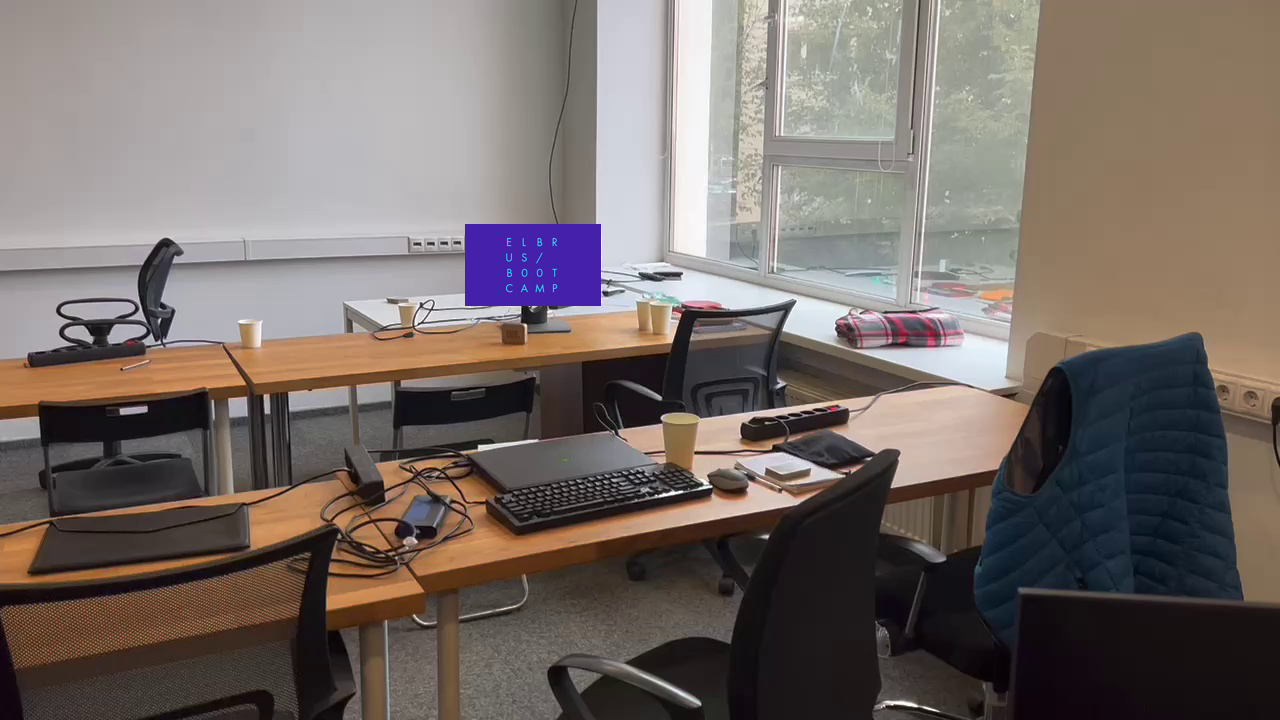

 12%|█▏        | 100/865 [01:11<08:45,  1.46it/s]

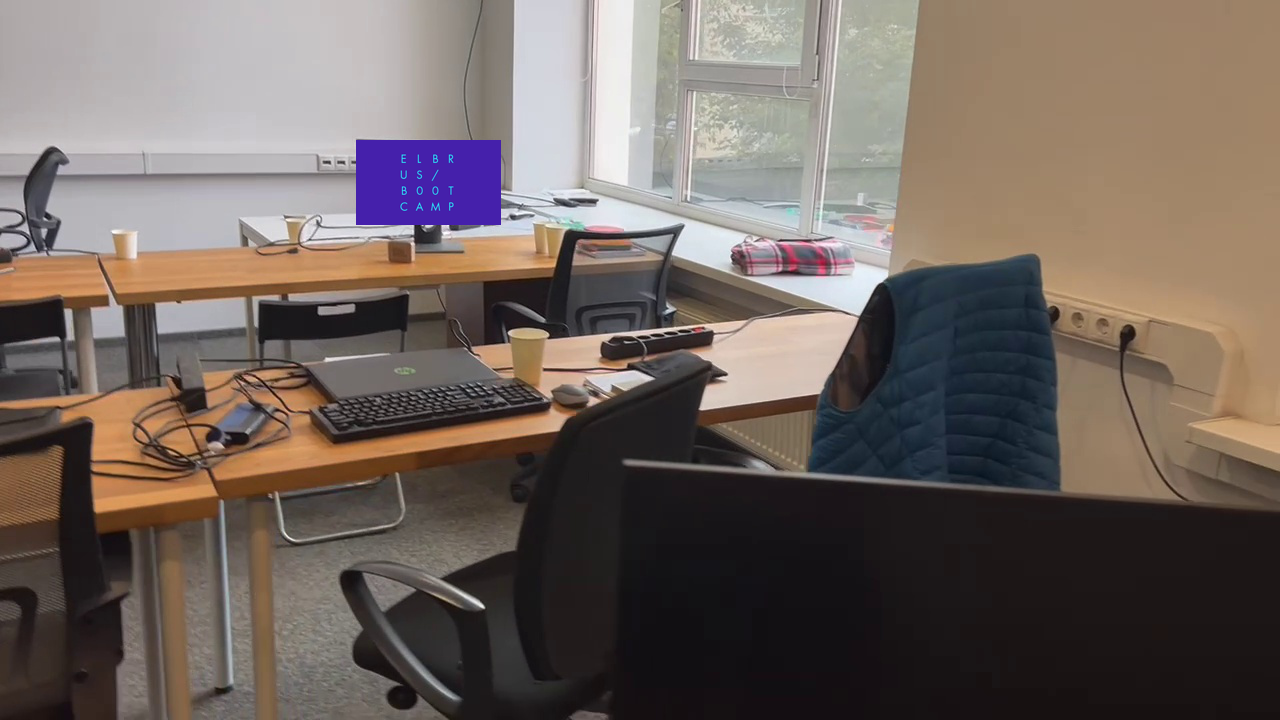

 23%|██▎       | 200/865 [02:27<17:45,  1.60s/it]

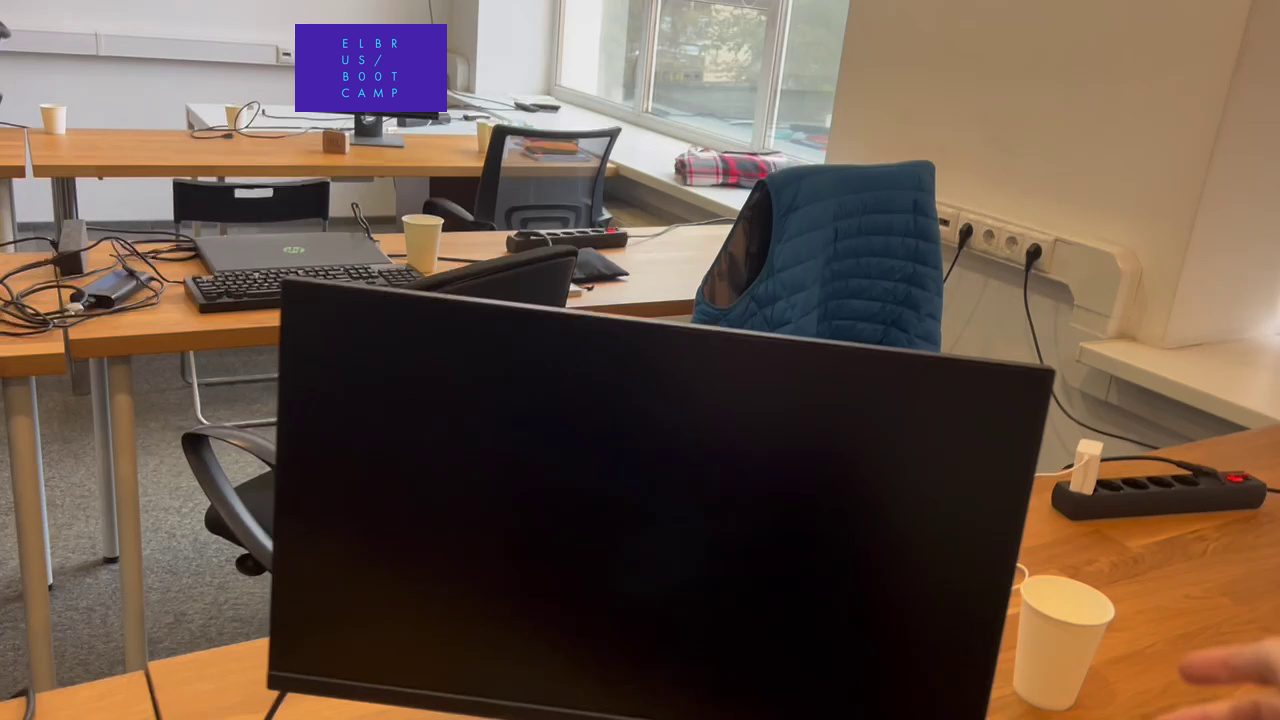

 35%|███▍      | 300/865 [04:36<18:55,  2.01s/it]

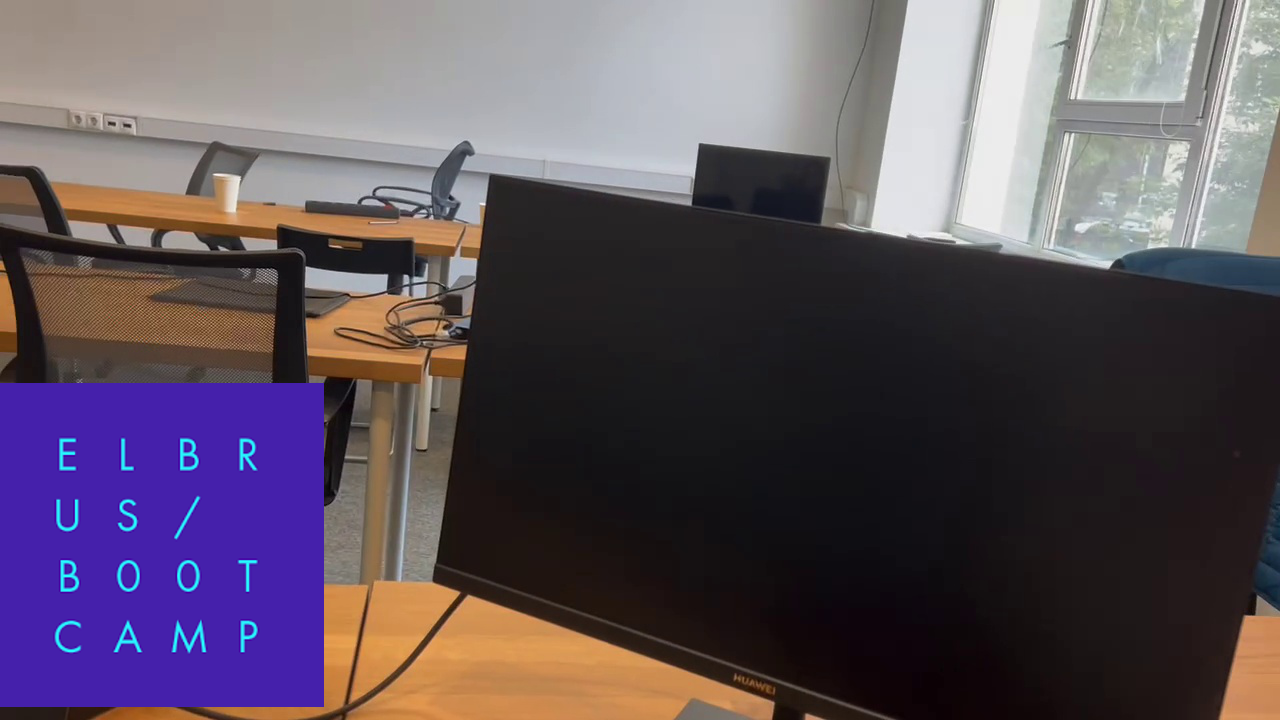

 46%|████▌     | 400/865 [06:21<05:19,  1.46it/s]

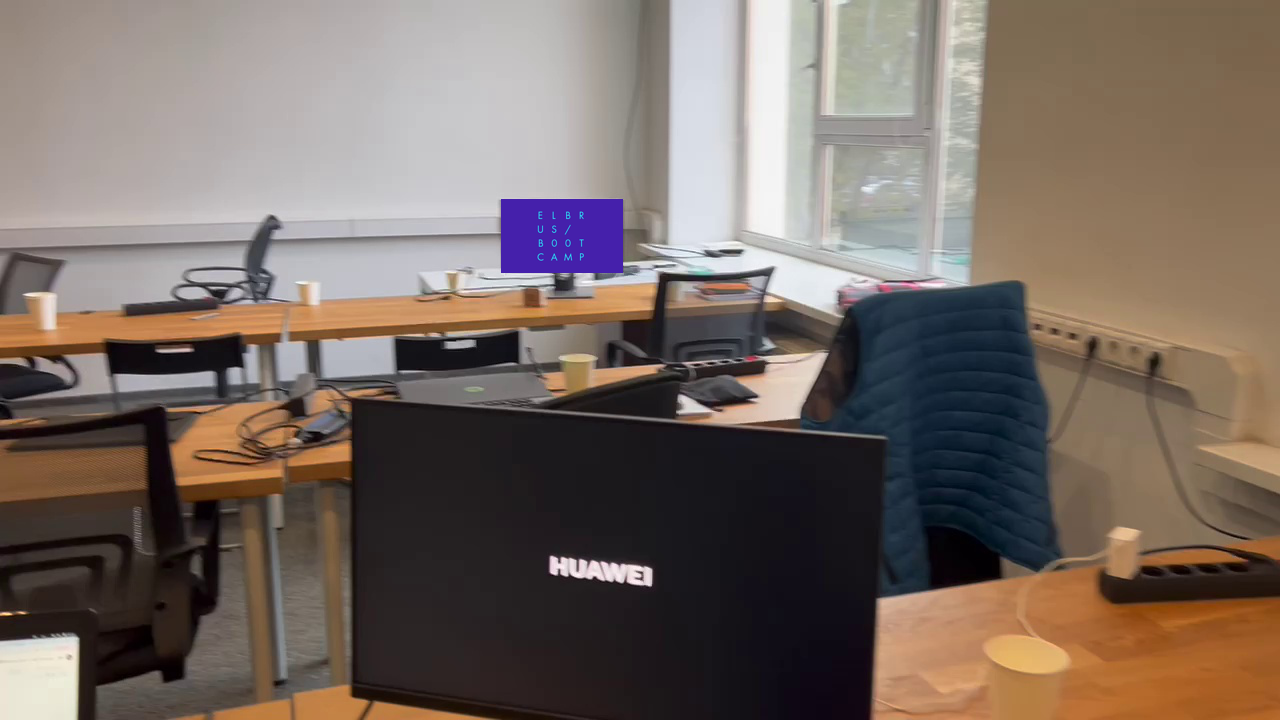

 58%|█████▊    | 500/865 [07:47<04:17,  1.42it/s]

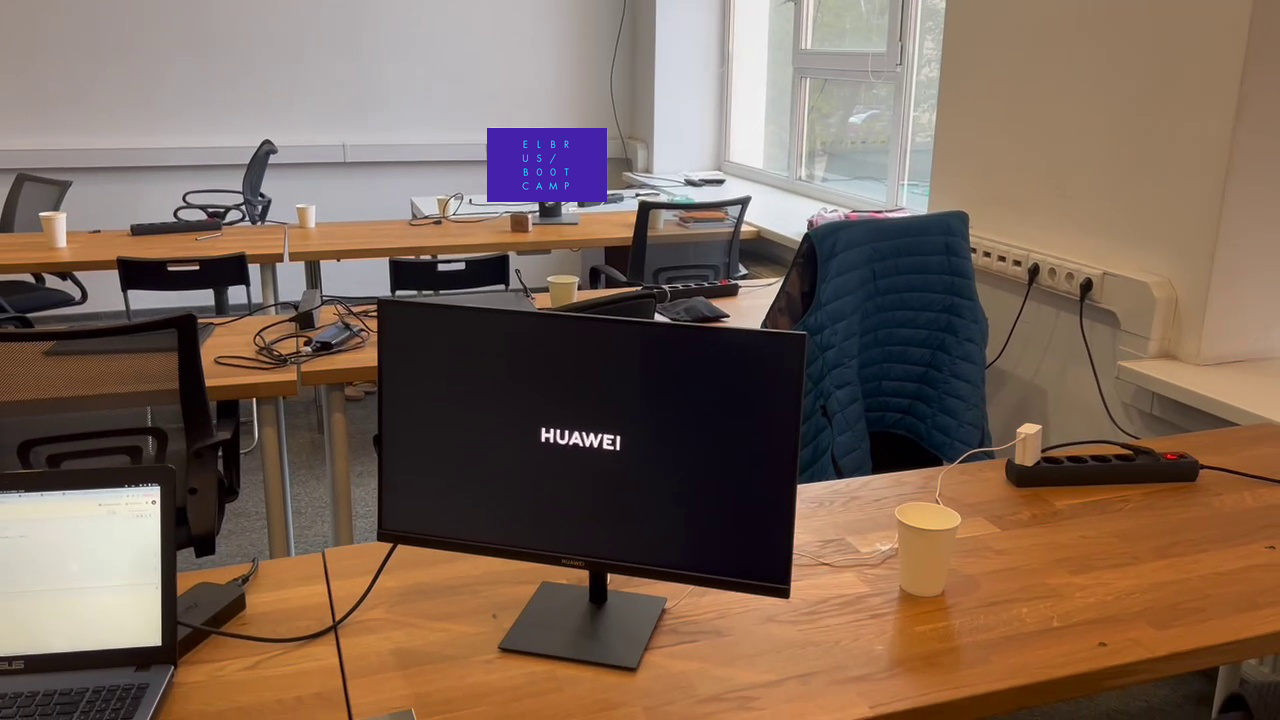

 69%|██████▉   | 600/865 [09:30<05:56,  1.34s/it]

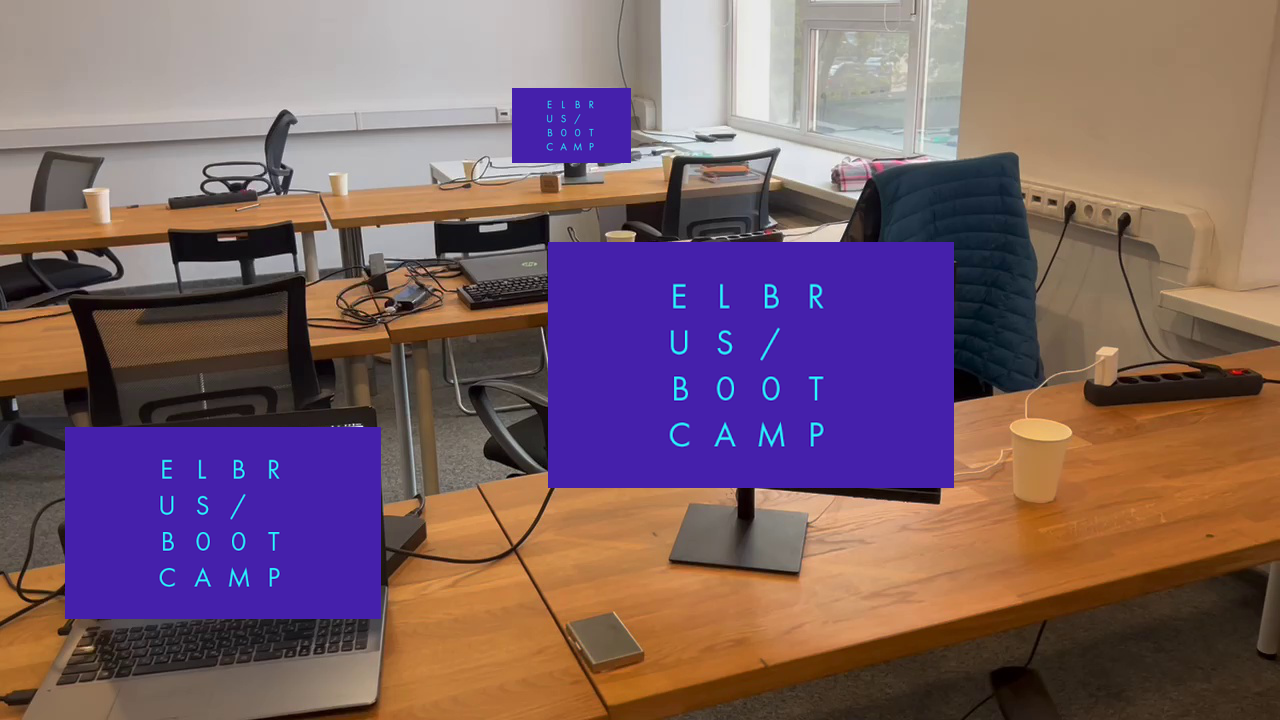

 81%|████████  | 700/865 [11:16<02:27,  1.12it/s]

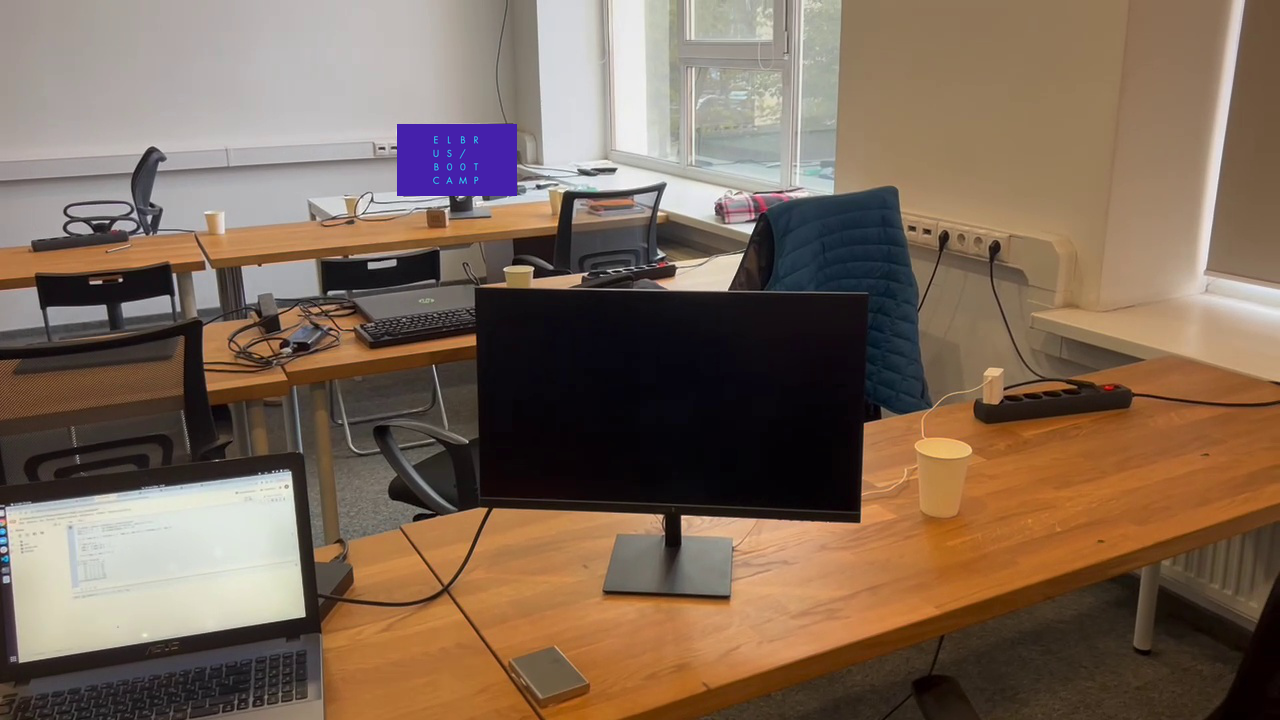

 92%|█████████▏| 800/865 [13:03<01:40,  1.54s/it]

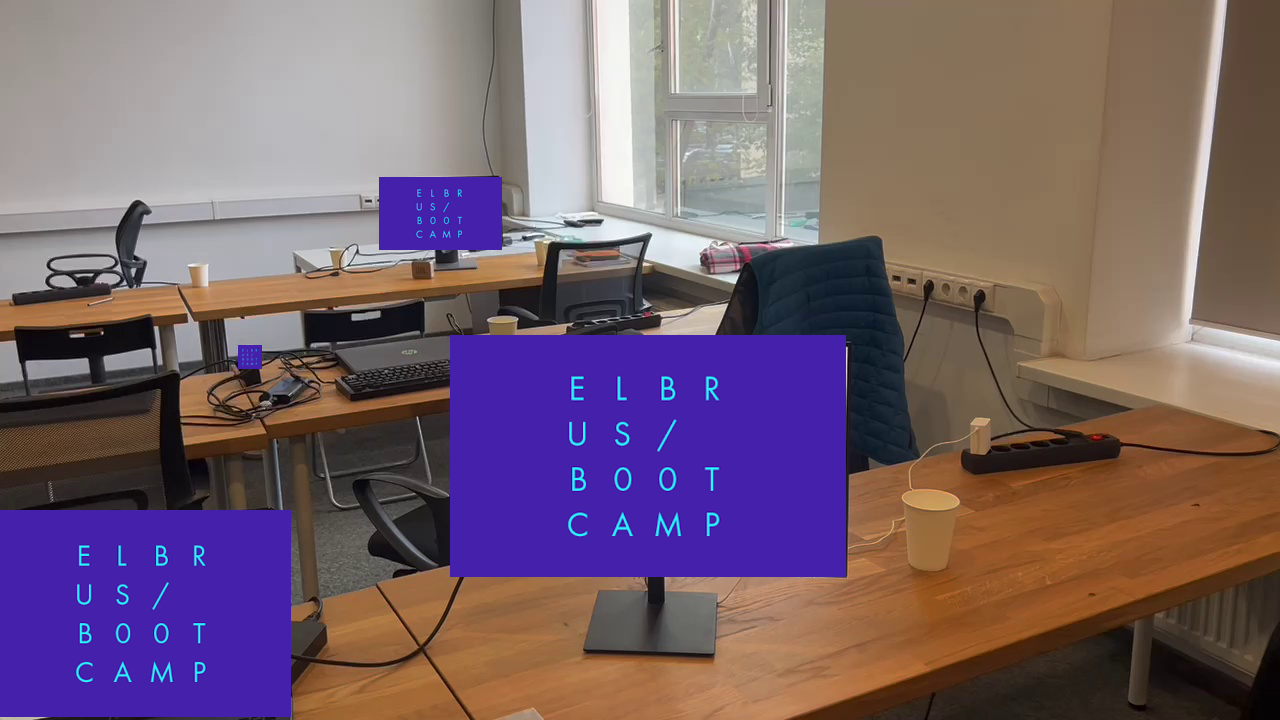

100%|██████████| 865/865 [14:09<00:00,  1.02it/s]


In [296]:
video = '/content/drive/MyDrive/IMG_7957.MOV'
adv = "/content/drive/MyDrive/elbrus.png"
path_video_out = '/content/drive/MyDrive/video_new_new.MOV'
path_shots = '/content/drive/MyDrive/shots2'
frame_out = '/content/drive/MyDrive/images2'

cv2.VideoCapture(video)

ads_video(video, adv, path_video_out, path_shots, frame_out, 0.01)